# Time Series Analysis Using ARIMA

Time series data has the special property of changing with time - observations for a single process or subject have a chronological order. Data points are therefore correlated with each other and violate the independent indentically distributed assumption that many regression-type models rely upon. Thus, time series data requires new methods for its analysis. One common class of models is the ARIMA model, or the auto-regressive integrated moving average model. It makes the important assumption of **stationarity**.  

## Stationarity

Stationarity - at least in the context of time series analysis - is the property that a time series is independent of time. Quantitatively speaking, this means that the statistical properties such as mean and variance are constant with respect to time. (Note that this refers to **weak stationarity**, whereas **strong stationarity** refers to the more stringent property that the distribution of time series data holds constant through time. In most analysis of time series, however, weak stationarity is sufficient.)

In other words, stationarity is achieved if the **lags**, or data at different points in time as the current point of reference, does not depend on time. One rough way to verify this is to simply plot the data. This notebook will be focusing on stock price data. 

In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

In [2]:
# pull monthly S&P500 data from the past 5 years
data = yf.download(tickers = ['^GSPC'], start = '2016-08-01', end = '2021-08-01', period = '1mo', interval = '1mo', 
                   group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)
# remove any rows with NAs
data = data.dropna(axis = 0)

[*********************100%***********************]  1 of 1 completed


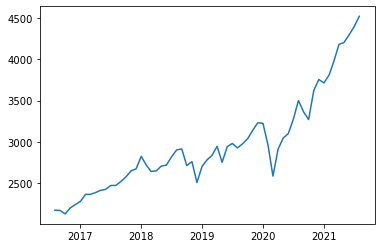

In [3]:
plt.plot(data['Close'])
plt.show()

One can easily tell that the value of the S&P 500 index is not stationary. As time passes, the mean and variance are surely non-constant as evident by the general upward trend. 

Stationarity can also be more closely checked using hypothesis testing. One common choice is the Augmented Dickey–Fuller(ADF) test, which attempts to reject the null hypothesis that a time series has a **unit root**(series with unit roots are not stationary). An alternative to the ADF test is the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test, which attempts to reject the null hypothesis that a series is stationary. Both tests have their pros and cons, and other alternatives can be found in this [Cross Validated post](https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916).

In [4]:
adf_test = dict(zip(['Test Statistic','p-value','#Lags Used','#Observations Used'], 
                    list(sm.tsa.stattools.adfuller(data['Close'], autolag='AIC')[:4])))
print("ADF:", adf_test)

kpss_test = dict(zip(['Test Statistic','p-value','Lags Used'],
                     list(sm.tsa.stattools.kpss(data['Close'], nlags='auto')[:3])))
print("KPSS:", kpss_test)

ADF: {'Test Statistic': 0.8105430291233423, 'p-value': 0.9918044601829685, '#Lags Used': 0, '#Observations Used': 60}
KPSS: {'Test Statistic': 1.1460540917434452, 'p-value': 0.01, 'Lags Used': 4}


C:\Users\Edwin\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The ADF test fails to reject the null hypothesis that there is a unit root and the KPSS test rejects the null hypothesis that the series is stationary. Thus we can be confident that our data is indeed non-stationary. 

In some cases, approximate stationarity can be achieved using simple log or square root transforms, which shrink changes in the mean and variance. However, a more common technique to impose stationarity is that of **differencing**. 

## Differencing

Differencing is the technique of turning a series of values into a series of changes in values. This is done by subtracting each data point by its immediate predecessor(or a data point $k$ units of time prior as seen fit). Thatis, for a given time series $$X = \{x_0, x_1, \cdots, x_n\}$$ the differenced series is then $$Y = \{x_i - x_{i-1}\}^{n}_{i = 1}$$

Differencing can be performed more than once, where a series differenced $$k$$ times is refered to as a $kth$-order differenced series. Intuitively, a first-order difference removes linear trends, a second-order difference removes quadratic trends, and so on. A differenced series can be easily "undifferenced" by a corresponding number of cumulative sums. 

In [5]:
def diff(seq, lag = 1):
    return(seq[lag:] - seq[:(len(seq) - lag)])

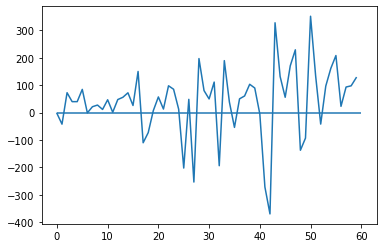

In [6]:
plt.plot(diff(data['Close'].values))
plt.hlines(0, xmin = 0, xmax = len(diff(data['Close'].values)))
plt.show()

It seems that a first-order difference of the data is enough to reach approximate stationarity. This can again be verified using the ADF and KPSS tests. 

In [7]:
adf_test = dict(zip(['Test Statistic','p-value','#Lags Used','#Observations Used'], 
                    list(sm.tsa.stattools.adfuller(diff(data['Close'].values), autolag='AIC')[:4])))
print("ADF:", adf_test)

kpss_test = dict(zip(['Test Statistic','p-value','Lags Used'],
                     list(sm.tsa.stattools.kpss(diff(data['Close'].values), nlags='auto')[:3])))
print("KPSS:", kpss_test)

ADF: {'Test Statistic': -7.602910607135352, 'p-value': 2.363278592823778e-11, '#Lags Used': 0, '#Observations Used': 59}
KPSS: {'Test Statistic': 0.3546217141947643, 'p-value': 0.09671477836432574, 'Lags Used': 5}


Another important property of time series data is autocorrelation, or self correlation.

## Autocorrelation

Autocorrelation (also known as serial correlation) measures the correlation between a series and itself after being lagged(e.g. shifted). It's a useful measure for uncovering any overall linear trends in the series over time, especially any that remain after the series is sufficiently differenced(overdifferencing a series can increase the variance of the time series, making accurate forecasts more difficult). 

Plotting the autocorrelation function(ACF) of a time series is a quick way to spot any significant trends in the data. Models aim to eliminate **significant** autocorrelations, or those that fall outside of the critical region. In this case, the critical region is defined by $\pm 1.96 \sqrt{n}$, where $n$ is the number of observations in the series. 

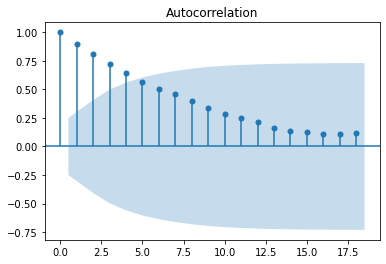

In [8]:
sm.graphics.tsa.plot_acf(data['Close'])
plt.show()

Looking at the ACF of the undifferenced series, observations are strongly correlated with those that immediately follow, with the autocorrelation decaying the more lags are introduced. It isn't until about $5$ lags that it dips within the critical region.

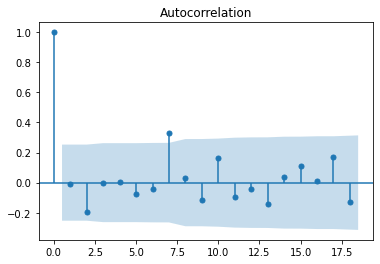

In [9]:
sm.graphics.tsa.plot_acf(diff(data['Close'].values))
plt.show()

After differencing, most of the autocorrelations fall within the critical region - save for the one at $7$ lags. A reasonable assumption would be to difference one more time. 

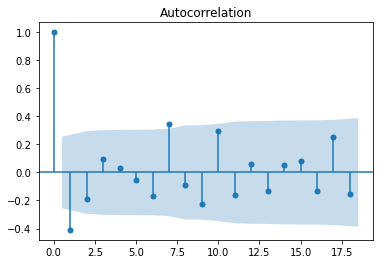

In [10]:
sm.graphics.tsa.plot_acf(diff(diff(data['Close'].values)))
plt.show()

Unfortunately, repeatedly differencing won't solve all our autocorrelation problems. This is an example of overdifferencing, which exacerbates autocorrelations (in this case, almost across the board). Rather than overdifferencing, remaining significant autocorrelations can be dealt with using the correct choice of model parameters. 

While the ACF is useful in identifying remaining trends, it can also be redundant in the trends it reveals. For example, the ACF for sinusoidal data is also sinusoidal, making it less than useful.

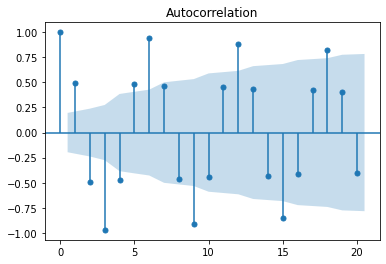

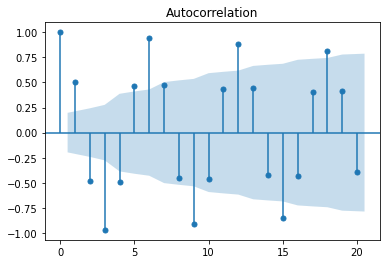

In [11]:
sindata = np.cos(np.arange(0, 100)*np.pi / 3) 
sm.graphics.tsa.plot_acf(sindata)
plt.show() 

# plot ACF of differenced data
sm.graphics.tsa.plot_acf(diff(sindata))
plt.show() 

Because of its cyclic/sinusoidal nature, differencing the data has no effect on the ACF. In order to reduce redundancy in the ACF, one can turn to the **partial autocorrelation function (PACF)**. 

## Partial Autocorrelation

The partial autocorrelation function(PACF) tells a similar story to the ACF. Both reveal trends in a series, but they differ in computed values. While autocorrelation has cyclical autocorrelations when the series is cyclical, the partial autocorrelation corrects for intermediate lags, causing the correlations to decay faster. One way the partial autocorrelation can be computed is calculating the correlation of two residuals obtained after regressing $x_{k+1}$ and $x_1$ on the intermediate observations $x_2, \cdots, x_k$ (citation needed). We can immediately see the difference by plotting the PACF.

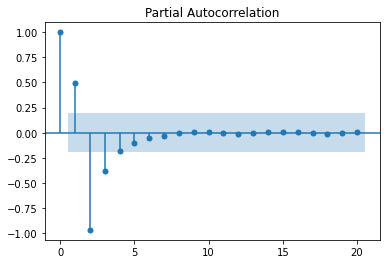

In [12]:
# used ywm because default method was acting up
sm.graphics.tsa.plot_pacf(sindata, method = 'ywm')
plt.show()

Rather than a cyclic behavior like the ACF, PACF quickly decays due to the redundant correlations being accounted and adjusted for. While this may sound like PACF makes ACF useless, both metrics have their respective uses in the ARIMA model, which will finally be discussed next.  

## ARIMA = AR + I + MA

ARIMA is the combination of three components: autoregression(**AR**), integrated (**I**), and moving-average(**MA**). We've actually already covered the **I** component - integrated refers to differencing. 

A quick note about differencing: while it is certainly possible to manually difference time series data before fitting a model to it, it is usually preferable to allow the model to take care of it. This mitigates the chances of human error and makes it easier to compute things like fitted values and forecasts(which requires undifferencing the data). What's more, fitted values of already differenced data can't be undifferenced to yield fitted values of undifferenced data. Basically, leave the differencing to the function(see this [Cross Validated post](https://stats.stackexchange.com/questions/471512/do-differencing-within-arima-or-do-differencing-first-before-fitting-arima) for a more complete discussion).

## AR Model

The second component to be discussed is the **autoregressive (AR)** model. As the name suggests, an autoregressive model uses previous lags as predictors of the next observation, with AR($p$) referring to an AR model fitted with $p$ lags: 

$$ y_t = \phi + \phi_{t-1} y_{t-1} + \cdots + \phi_{p-t} y_{p-t} + \epsilon_t $$

where $\epsilon_t$ is assumed to have mean $0$. On the surface, the AR model resembles a linear regression model(with independent predictors swapped out for lags). In fact, the coefficients $\phi_i$ can be solved for using the normal equations. This unique setup also allows for different methods of solution, one popular example being the **Yule-Walker** equations (in fact, the computations required by the Yule-Walker equations make computing the PACF rather simple, see these [lecture notes](http://www-stat.wharton.upenn.edu/~steele/Courses/956/Resource/YWSourceFiles/YW-Eshel.pdf) for details). 

Note that the extent of forecasting is limited by the order of the model, as each new prediction is fed into the prediction of the next one. For example, in an AR(1) model, we can only forecast one step ahead, as any steps afterward are not dependent on the dataset and eventually decay to the mean (showing this empirically is left to the reader). 

To determine an approximate order $k$ for an AR process, the PACF is often used. In theory, an AR(p) process should see a steep cutoff in partial autocorrelation for lags greater than $p$, as the first $p$ lags fully describe the current observation and once adjusted for, leave the correlation close to $0$.

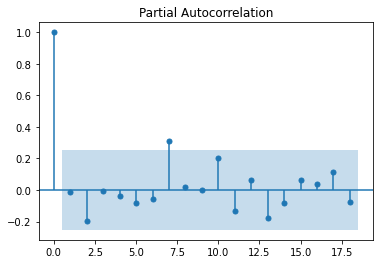

In [13]:
sm.graphics.tsa.plot_pacf(diff(data['Close'].values), method = 'ywm')
plt.show()

From the PACF plot of the differenced series, it seems there is a significant value at lag $7$. Thus, AR($7$) is a candidate model, albiet a bit complex for such a small dataset. 

In [14]:
# p=7, d=1, q=0(not part of AR model)
ar = sm.tsa.arima.ARIMA(data['Close'].values, order = (7,1,0))
ar_res = ar.fit()
print(ar_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:                 ARIMA(7, 1, 0)   Log Likelihood                -373.505
Date:                Sat, 11 Sep 2021   AIC                            763.011
Time:                        02:13:55   BIC                            779.765
Sample:                             0   HQIC                           769.564
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0749      0.096      0.781      0.435      -0.113       0.263
ar.L2         -0.0989      0.134     -0.738      0.461      -0.362       0.164
ar.L3          0.0789      0.145      0.545      0.5

Looking first at the coefficients, it's a bad sign that almost all of them are nonsignificant, that is there is no significant difference between a coefficient of zero and a nonzero coefficient. In other words, the model is too complex and probably not much different from a random walk model(or AR($0$) model). For a detailed description of the interpretation of the other statistics and tests provided in the output summary, refer to this useful [Analyzing Alpha blog post](https://analyzingalpha.com/interpret-arima-results).

Although easily interpretable, this method of evaluating individual parameters can be difficult to quantify. Two other ways of assessing a model's fit and performance can be done through the AIC/BIC and mean absolute percentage error (MAPE) measures. AIC/BIC quantifies how well a model fits the data it is trained on, with lower values corresponding to better fits, but requires background knowledge or other models for comparison. MAPE, on the other hand, provides an easily understandable measure of how a model performs in terms of accurate predictions.

The MAPE can be computed using a rolling window of data and repeatedly fitting a new model to it. 

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    forecasts = []
    for i in range(7, len(data['Close'].values)):
        model = sm.tsa.arima.ARIMA(data['Close'].values[:i], order=(7,1,0))
        model_res = model.fit()
        yhat = model_res.forecast()[0]
        forecasts.append(yhat)
        
np.abs((data['Close'].values[7:] - forecasts) / data['Close'].values[7:]).sum() / len(forecasts)

0.04009592608913736

While an underwhelming result, this demonstrates that analyzing the PACF is not a perfect solution to fitting an AR model. One should also be wary of fitting small datasets to higher order AR models, as overfitting is likely to occur. 

## MA Model

The third component is the **moving-average (MA)** model. Not to be confused with the moving average(computing the average of a rolling window), this model consists of a linear combination of previous error terms structured similarly to the AR model. A MA($q$) refers to an MA model fitted with $q$ lags.

$$ y_t = \mu + \theta_{t-1}\epsilon_{t-1} + \cdots + \theta_{t-q}\epsilon_{t-q} $$

where $\mu$ is the mean of the process and $\epsilon_i$ is the white noise error term of the $i$th lag. Because the error terms are not observable, other computational methods must be used to solve for the coefficients. 

To determine the approximate order of an MA process, one can utilize the ACF function. In theory, there should be a steep cutoff in the autocorrelation for any lags larger than $q$, as the white noise terms are assumed to be i.i.d. and therefore independence will ensure no correlation.

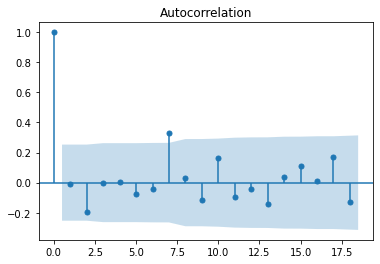

In [15]:
sm.graphics.tsa.plot_acf(diff(data['Close'].values))
plt.show()

From the ACF plot, it seems an MA($7$) may be appropriate for the data. This order is also suspiciously high for such a small set of data. 

In [16]:
ma = sm.tsa.arima.ARIMA(data['Close'].values, order = (0,1,7))
ma_res = ma.fit()
print(ma_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:                 ARIMA(0, 1, 7)   Log Likelihood                -373.214
Date:                Sat, 11 Sep 2021   AIC                            762.427
Time:                        02:13:59   BIC                            779.182
Sample:                             0   HQIC                           768.981
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0682      0.101      0.678      0.498      -0.129       0.265
ma.L2         -0.0523      0.110     -0.476      0.634      -0.268       0.163
ma.L3         -0.0880      0.111     -0.793      0.4

The MA($7$) model seems to be a better fit than the AR($7$) model, sporting more significant coefficients and a lower AIC/BIC score. However, it still seems to overfit the data as half the coefficients are nonsignificant. 

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    forecasts = []
    for i in range(7, len(data['Close'].values)):
        model = sm.tsa.arima.ARIMA(data['Close'].values[:i], order=(0,1,7))
        model_res = model.fit()
        yhat = model_res.forecast()[0]
        forecasts.append(yhat)
        
np.abs((data['Close'].values[7:] - forecasts) / data['Close'].values[7:]).sum() / len(forecasts)

nan

The forecasting yielded at least a couple NaNs, which may suggest overfitting(see this [Cross Validated post](https://stats.stackexchange.com/questions/203142/na-in-arima-model-is-it-suggest-that-the-model-is-over-fit) for possible issues). This isn't a good sign, but perhaps combining it with the AR($7$) model will alleviate some issues.

## Fitting ARIMA 

The AR and MA models provide different motivations and interpretations for describing and forecasting a time series. Both have their upsides and downsides. Perhaps combining them into a single model will yield the best of both worlds. If one refers to the ACF and PACF plots to decide the coefficients, fitting an ARIMA($7,1,7$) is a reasonable line of action. 

In [17]:
arma = sm.tsa.arima.ARIMA(data['Close'].values, order = (7,1,7))
arma_res = arma.fit()
print(arma_res.summary())

C:\Users\Edwin\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\envs\finance\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:                 ARIMA(7, 1, 7)   Log Likelihood                -371.780
Date:                Sat, 11 Sep 2021   AIC                            773.560
Time:                        02:14:06   BIC                            804.976
Sample:                             0   HQIC                           785.849
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0960      0.582      0.165      0.869      -1.044       1.236
ar.L2         -0.3693      0.695     -0.531      0.595      -1.732       0.994
ar.L3          0.2867      0.476      0.603      0.5

C:\Users\Edwin\miniconda3\envs\finance\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Unfortunately, combining the two models did not do much to improve the fit, in fact the AIC/BIC scores are higher than those of the MA($7$) model. This makes sense since AR($7$) had a rather high AIC/BIC to begin with. 

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    forecasts = []
    for i in range(7, len(data['Close'].values)):
        model = sm.tsa.arima.ARIMA(data['Close'].values[:i], order=(7,1,7))
        model_res = model.fit()
        yhat = model_res.forecast()[0]
        forecasts.append(yhat)

np.abs((data['Close'].values[7:] - forecasts) / data['Close'].values[7:]).sum() / len(forecasts)

LinAlgError: Schur decomposition solver error.

Worse still, the rolling window forecasting ran into errors with fitting the model. This may be due to the nature of the data, or due to overfitting to it. Either way, this isn't great news. 

These results beg the question of what a decent model would be for this data. One convenient way of searching for an optimal model is to use an Auto ARIMA function which employs a grid search of optimal parameters. Optimality in this case refers to optimizing a measure of fit such as AIC or BIC. While it doesn't guarantee a globally optimal set of parameters, Auto ARIMA will return a locally optimal set. 

In [18]:
import pmdarima as pm
auto_fit = pm.auto_arima(data['Close'].values, start_p=7, start_q=7,
                         max_p=10, max_q=10,
                         d=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
print(auto_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(7,1,7)(0,0,0)[0] intercept   : AIC=771.903, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=756.097, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=758.089, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=758.084, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=759.511, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.703 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -376.048
Date:                Sat, 11 Sep 2021   AIC                            756.097
Time:                        02:14:16   BIC                            760.286
Sample:                             0   HQIC                           757.735
                    

The Auto ARIMA search concluded that an ARIMA(0, 1, 0) model, or a random walk model has the lowest AIC and is therefore the ideal fit for our data. This is backed up by the computed MAPE:

In [20]:
forecasts = []
for i in range(7, len(data['Close'].values)):
    model = sm.tsa.arima.ARIMA(data['Close'].values[:i], order=(0,1,0))
    model_res = model.fit()
    yhat = model_res.forecast()[0]
    forecasts.append(yhat)
        
np.abs((data['Close'].values[7:] - forecasts) / data['Close'].values[7:]).sum() / len(forecasts)

0.03501403242849977

With a lower AIC/BIC and MAPE, the ARIMA($0,1,0$) model is not only a better fit but also a better forecaster. Sometimes the simplest model is the best one to use.

## Related Tangents

It turns out that AR and MA use differing diagnostic functions (PACF versus ACF) because the processes are "invertible" if the coefficients are within the unit circle, that is an AR or MA process with finite terms can be reexpressed as an infinite process of the other model. For instance, if we consider the PACF of an (invertible) MA($q$) model, it decays slowly because it is also the PACF of an AR($\infty$) model whose infinite terms prevent any sharp cutoffs. See this [Cross Validated post](https://stats.stackexchange.com/questions/112932/interpretation-of-the-partial-autocorrelation-function-for-a-pure-ma-process?rq=1) for more mathematical rigor.

One can also approximate an ARIMA($p, d, q$) using an ARMA(p+d, q) model. This can be seen empirically in this [Cross Validated post](https://stats.stackexchange.com/questions/209727/arma-when-arima-should-be-used)

Finally, statsmodels actually does not use traditional methods such as MLE or the Yule-Walker equations, but rather something called state space estimation to estimate model parameters. The details of state space models will be in a future post.

## References

[1] Nielsen, Aileen. Practical Time Series Analysis. O'Reilly Media, 2019. 

[2] Brockwell, Peter; Davis, Richard (2009). Time Series: Theory and Methods (2nd ed.). New York: Springer. ISBN 9781441903198.

[3] https://online.stat.psu.edu/stat510/

[4] https://analyzingalpha.com/interpret-arima-results

[5] https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916

[6] https://stats.stackexchange.com/questions/471512/do-differencing-within-arima-or-do-differencing-first-before-fitting-arima

[7] https://stats.stackexchange.com/questions/203142/na-in-arima-model-is-it-suggest-that-the-model-is-over-fit

[8] https://stats.stackexchange.com/questions/112932/interpretation-of-the-partial-autocorrelation-function-for-a-pure-ma-process?rq=1

[9] https://stats.stackexchange.com/questions/209727/arma-when-arima-should-be-used

[10] http://www-stat.wharton.upenn.edu/~steele/Courses/956/Resource/YWSourceFiles/YW-Eshel.pdf